# Analyse der Abwesenheiten in Gemeinderatssitzungen

In [328]:
import requests
import pandas as pd
import time 
import datetime
from datetime import timedelta
import glob
import re
import PyPDF2

In [329]:
#Erstelle Start und Endpunkte für Suche
today = datetime.datetime.today().strftime('%d.%m.%Y')
#start = '07.05.2014'
#end = '15.05.2018'
#start = '16.05.2018'
#end = today
#Zapfe die Gemeinderat API an
url_protokolle = 'https://www.gemeinderat-zuerich.ch/api/Protokoll?datumVon='+start+'&datumBis='+end
response = requests.get(url_protokolle)
protokolle = response.json()
print(len(protokolle), 'wurden in diesem Zeitraum gefunden')

397 wurden in diesem Zeitraum gefunden


In [330]:
#Um die Protokolle herunterzuladen
for protokoll in protokolle:
    url = 'https://www.gemeinderat-zuerich.ch/DocumentLoader.aspx?Typ=protokoll&ID='+str(protokoll['Id'])+'&FileName='+protokoll['FileName']
    r = requests.get(url, allow_redirects=True)
    open('protokolle/'+protokoll['FileName'], 'wb').write(r.content)

In [331]:
#Um die Protokolle auszuwerten
data = []
protokolle_count = 0
for protokoll in protokolle:
    if len(protokoll['FileName'])<=29:
        dic = {'file':'',
              'anwesend':'',
              'abwesende':''}
        dic['file'] = 'protokolle/'+protokoll['FileName']
        #print(dic['file'])
        pdfFileObj = open('protokolle/'+protokoll['FileName'], 'rb')
        pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
        pageObj = pdfReader.getPage(0)
        protokoll = pageObj.extractText()
        anwesend = protokoll.strip().replace('\n', '').split('Anwesend:')[1]
        dic['anwesend'] = anwesend.split('Mitglieder')[0].strip().replace('\n', '')
        try:
            abwesend = protokoll.replace('\n', '').split('Abwesend:')[1]
        except:
            abwesend = "Der Rat 0"
        dic['abwesende'] = abwesend.split('Der Rat')[0].strip()
        data.append(dic)
        protokolle_count += 1
df = pd.DataFrame(data)
df.head()

,file,anwesend,abwesende
0,protokolle/GR-Protokoll 20180418.199.pdf,123,"Alexander Brunner (FDP), Kurt Hüssy (SVP)"
1,protokolle/GR-Protokoll 20180411.198.pdf,123,"Kurt Hüssy (SVP), Raphaël Tschanz (FDP)"
2,protokolle/GR-Protokoll 20180404.197.pdf,118,"Samuel Balsiger (SVP), Urs Helfenstein (SP), K..."
3,protokolle/GR-Protokoll 20180328.196.pdf,123,"Kurt Hüssy (SVP), Thomas Schwendener (SVP)"
4,protokolle/GR-Protokoll 20180321.195.pdf,120,"Markus Baumann (GLP), Kurt Hüssy (SVP), Andrea..."


In [332]:
#Vakanzen erkennen
df['vakanz'] = df.abwesende.str.extract('(\d) Sitz[e]* vakant')
df['vakanz'][df['vakanz'].isna()] = 0
df['vakanz'] = df['vakanz'].astype(int)
df['anwesend'] = df['anwesend'].astype(int) 
df['abwesende_count'] = 125-df['vakanz']-df['anwesend']

4.0 Räte fehlen im Schnitt. (Start: 07.05.2014 End: 15.05.2018)


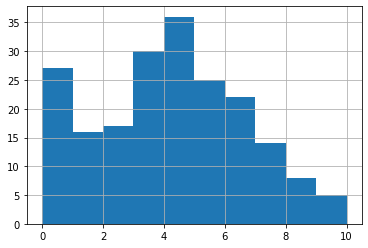

In [333]:
df['abwesende_count'].hist()
print(round(df['abwesende_count'].median(),1), 'Räte fehlen im Schnitt. (Start: '+start+' End: '+end+')')

In [334]:
def get_missing(row):
    missinglist = row['abwesende'].split(', ')
    return missinglist

In [351]:
missings = []
for sitzung in df.apply(get_missing, axis=1):
    for missing in sitzung:
        missings.append(missing)
missings = pd.DataFrame(missings)
df_missings = missings[0].value_counts().reset_index()

In [352]:
df_missings.columns = ['name','count']
df_missings['name'] = df_missings['name'].str.replace('-','')
df_missings['name'] = df_missings['name'].str.replace(' ','')
df_missings['name'] = df_missings['name'].str.replace('Ratspräsident','')
df_missings['name'] = df_missings['name'].str.replace('Ratspräsidentin','')
df_missings['name'] = df_missings['name'].str.strip()


In [353]:
df_missings = df_missings.groupby('name').sum().reset_index()

In [354]:
df_missings['sitzungen'] = protokolle_count
df_missings['share'] = round(df_missings['count']/df_missings['sitzungen']*100,1)
df_missings = df_missings.sort_values('count',ascending=False)

In [355]:
df_missings['partei'] = df_missings['name'].str.extract('\((.*)\)')

In [356]:
pd.set_option('display.max_rows', None)
df_missings[df_missings['partei']=='GLP']

,name,count,sitzungen,share,partei
41,GuidoHüni(GLP),35,200,17.5,GLP
2,AdrianGautschi(GLP),18,200,9.0,GLP
73,MartinLuchsinger(GLP),12,200,6.0,GLP
42,GuidoTrevisan(GLP),11,200,5.5,GLP
106,ShaibalRoy(GLP),11,200,5.5,GLP
65,MarkusBaumann(GLP),8,200,4.0,GLP
55,MaleicaLandolt(GLP),8,200,4.0,GLP
100,RonnySiev(GLP),5,200,2.5,GLP
75,MatthiasWiesmann(GLP),5,200,2.5,GLP
104,SamuelDubno(GLP),4,200,2.0,GLP


In [343]:
#df_missings.to_csv('missingnames_1418.csv', index=False)

In [347]:
df_missings_party = df_missings.groupby('partei').sum().reset_index()
df_missings_party = df_missings_party[['partei','count']]

In [325]:
df_missings_party.to_csv('absenzen_pro_partei_14_18.csv', index=False)